In [27]:
#import the packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import Counter
from statistics import mode
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import geopandas
import rtree
import seaborn as sns
import haversine as hs
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'geopandas'

# 1 Import data

In [ ]:
# import the data into pandas dataframes
hvc_am0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AM0.csv", sep=";")
hvc_ar0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AR0.csv", sep=";")
hvc_customer_reviews = pd.read_csv("../ACRM-GROUP-13/data/HVC_CUSTOMER_REVIEWS.csv", sep=";")
hvc_depot = pd.read_csv("../ACRM-GROUP-13/data/HVC_DEPOT.csv", sep=";")
hvc_hvdayofweek = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVDAYOFWEEK.csv", sep=";")
hvc_hvposition = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVPOSITION_CORRECT.csv", sep=";")
hvc_hvroutetemplate = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVROUTETEMPLATE.csv", sep=";")
hvc_hvvisitoutcome = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITOUTCOME.csv", sep=";")
hvc_hvvisitresult = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITRESULT.csv", sep=";")
hvc_so0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_SO0.csv", sep=";")
hvc_visitresultdetails = pd.read_csv("../ACRM-GROUP-13/data/HVC_VISITRESULTDETAILS.csv", sep=";")

In [ ]:
#Data conversion
hvc_hvdayofweek["HVDAYOFWEEK_NRID"] = hvc_hvdayofweek["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"] = hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvroutetemplate["HVDAYOFWEEK_NRID"] = hvc_hvroutetemplate["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["WEEKORDER"] = hvc_hvroutetemplate["WEEKORDER"].astype(int)
hvc_hvvisitoutcome["HVOUTCOME_NRID"] = hvc_hvvisitoutcome["HVOUTCOME_NRID"].astype(int)
hvc_visitresultdetails["HVVISITRESULT_NRID"] = hvc_visitresultdetails["HVVISITRESULT_NRID"].astype(int)
hvc_so0["SO0_NRID"] = hvc_so0["SO0_NRID"].astype(int)
hvc_so0["HVROUTETEMPLATE_NRID"] = hvc_so0["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvvisitresult["DATEONLY"] = pd.to_datetime(hvc_hvvisitresult["DATEONLY"])
hvc_hvvisitresult["VISITDATE"] = pd.to_datetime(hvc_hvvisitresult["VISITDATE"])

## 2 Explore the Data

## 2.1 hvc_customer_reviews

In [ ]:
# inspect table
hvc_customer_reviews

In [ ]:
# inspect the first 5 reviews
hvc_customer_reviews.head(5)

In [ ]:
# inspect the total number of reviews
len(hvc_customer_reviews["SO0_NRID"].unique())

In [ ]:
# checking dtypes
hvc_customer_reviews.dtypes

In [ ]:
# checking kind of reviews
pd.unique(hvc_customer_reviews["REVIEW"])

In [ ]:
# inspect some descriptive statistics with respect to the transaction amount
hvc_customer_reviews["REVIEW"].describe()

In [ ]:
# proportion of good or excellent reviews
sum((hvc_customer_reviews["REVIEW"] == "Good service, satisfied") + (hvc_customer_reviews["REVIEW"] == "Excellent service, very satisfied")) / len(hvc_customer_reviews)

In [ ]:
# proportion of excellent reviews
sum((hvc_customer_reviews["REVIEW"] == "Excellent service, very satisfied")) / len(hvc_customer_reviews)



In [ ]:
# proportion of good reviews
sum((hvc_customer_reviews["REVIEW"] == "Good service,  satisfied")) / len(hvc_customer_reviews)

In [ ]:
# proportion of terrible reviews
sum((hvc_customer_reviews["REVIEW"] == "Very bad service, very unsatisfied")) / len(hvc_customer_reviews)

## 2.2 hvc_hvpostition

In [ ]:
# customer position
hvc_hvposition

In [ ]:
# inspect first 5 observations of customer location
hvc_hvposition.head(5)

In [ ]:
# inspect last 5 observations of customer location
hvc_hvposition.tail(5)

In [ ]:
# total number of locations of unique customers
len(hvc_hvposition["SO0_NRID"].unique())

In [ ]:
# more locations then customers
len(hvc_hvposition["SO0_NRID"].unique()) > len(hvc_so0["SO0_NRID"].unique())


## 2.3 hvc_so0_nrid

In [ ]:
# inspect first 5 observations of customers
hvc_so0.head(5)

In [ ]:
# inspect last 5 observations of customers
hvc_so0.tail(5)

In [ ]:
# inspect total number of unique customers
len(hvc_so0["SO0_NRID"].unique())

In [ ]:
# get some descriptive statistics with respect to the spoken language as well as the season type of the customers
hvc_so0[["LANGUAGE", "SEASON_TYPE"]].describe()

In [ ]:
# get the counts for every season type
hvc_so0["SEASON_TYPE"].value_counts()

In [ ]:
# get the counts for every spoken language
hvc_so0["LANGUAGE"].value_counts()

# 3 Analysis

## 3.1 Customer locations

In [ ]:
### Clustering the customer positions

## Clustering the longitude and latitude

from sklearn.cluster import KMeans
plt.figure(figsize = (10,10))

# initialize the cluster algorithm with 4 classes
kmeans_model = KMeans(n_clusters=4)

# fit the kmeans model onto the data
kmeans_model.fit(hvc_hvposition[["LONG","LAT"]])

# get all the cluster labels
cluster_labels = kmeans_model.labels_

# define color map
color_map = {0: "green", 1: "red", 2: "blue", 3: "yellow"}

# get colors for each cluster label
cluster_colors = [color_map[label] for label in cluster_labels]

# plot data with cluster colors
plt.scatter(hvc_hvposition["LONG"], hvc_hvposition["LAT"], color=cluster_colors)
plt.show()

In [ ]:
# adding a map
belgium = gpd.read_file("./data/Arrondissementen.json")
crs = 'epsg:4326'
base = belgium.plot(color='white', edgecolor='black', figsize = (20,20))
gdf = gpd.GeoDataFrame(hvc_hvposition, crs = crs,geometry=gpd.points_from_xy(hvc_hvposition["LONG"], hvc_hvposition["LAT"]))


gdf.plot(ax = base, color = "red",markersize = 10)

plt.show()

## 3.2 What do the  customers buy? 

In [28]:
customer_id = 721110.0

In [29]:
# join transactions with transaction details with products
transactions_products = hvc_hvvisitresult.merge(hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner")\
                                         .merge(hvc_ar0, on="AR0_NRID", how="inner") 

In [30]:
# check
transactions_products.head(3)

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,DESCRIPTION,CATEGORY,FAMILY,PRICE
0,55681456,719952,23186288605042,2,2021-10-24 12:20:01,2019-05-06,16.9,cash,55681457,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
1,55681507,1453609,19946584592834,2,2021-10-24 12:13:50,2019-05-06,7.4,cash,55681508,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
2,55714770,1246568,18934048107254,2,2021-10-24 22:08:39,2019-05-06,11.1,cash,55714771,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4


In [31]:
# get all the transactions for customer
transactions_products_customer = transactions_products[transactions_products["SO0_NRID"] == customer_id]

# get all transactions with positive outcome
transactions_products_customer = transactions_products_customer[transactions_products_customer["HVOUTCOME_NRID"] == 2]

In [32]:
# get total number of products bought by the customer
transactions_products_customer["QUANTITY"].sum()

22.0

## 3.3 Unique list of unique products a customer bought

In [33]:
# define a function that accepts a customer id, the transactions data, transactions details data and product data
def get_products(cust_id, transactions, transaction_details, products):
    

    # join transactions with transaction details with products
    transactions_products = transactions.merge(transaction_details, on="HVVISITRESULT_NRID", how="inner") \
                                        .merge(products, on="AR0_NRID", how="inner")
    
    # get transactions of customer 
    transactions_products_cust = transactions_products[transactions_products["SO0_NRID"] == cust_id]
    
    # only get transactions of succesfull visits
    transactions_products_cust = transactions_products_cust[transactions_products_cust["HVOUTCOME_NRID"] == 2]
    
    # get total amount of products bought by the customer
    total_products = transactions_products_cust["QUANTITY"].sum()
    
    # get total number of unique products bought by the customer
    total_unique_products = len(transactions_products_cust["DESCRIPTION"].unique())
    
    # return
    return(total_products, total_unique_products)

In [34]:
# check
get_products(cust_id=721110.0, 
                  transactions=hvc_hvvisitresult, 
                  transaction_details=hvc_visitresultdetails, 
                  products=hvc_ar0)

(22.0, 10)

## 3.4 Which customers have the highest CLV?



In [35]:
def get_clv(cust_id, transactions):
    
    # get customer transactions
    cust_transactions = transactions[transactions["SO0_NRID"] == cust_id]
    # get transactions with positive outcome
    cust_transactions_pos = cust_transactions[cust_transactions["HVOUTCOME_NRID"] == 2]
    # get clv
    clv = np.sum(cust_transactions["AMOUNT"])
    # return clv
    return(clv)

In [36]:
# check
clv = get_clv(cust_id=721110.0, transactions=hvc_hvvisitresult)
print(clv)

183.60000000000002


In [37]:
# CLV for private customers
private_cust = hvc_so0[hvc_so0["CUST_TYPE"] == "Private"]


for x in private_cust["SO0_NRID"]:
    clv = get_clv(cust_id=x, transactions=hvc_hvvisitresult)
print(clv)

# CLV 

    

    

0.0


In [38]:
#Sales by customer type in a certain year

def sales_by_customer_type(desired_year):

    # get the month of each transaction date and store it in new column
    hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

    #merge
    transactions_2020 = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")

    # get transactions from 2020 only
    transactions_2020 = transactions_2020[(transactions_2020["DATEONLY"] >= pd.Timestamp(year=desired_year, day=1, month=1)) & (transactions_2020["DATEONLY"] < pd.Timestamp(year=desired_year + 1, month=1, day=1))]

    # get transactions with succesfull outcome
    transactions_2020 = transactions_2020[transactions_2020["HVOUTCOME_NRID"] == 2]


    # get transactions by 'private customers'
    private_transactions_2020 = transactions_2020[transactions_2020["CUST_TYPE"] == "Private"]

    # get the total sales for each month for 'private customers'
    private_monthly_sales = private_transactions_2020.groupby("MONTH")["AMOUNT"].sum().reset_index()

    # get transactions by 'Horeca customers'
    horeca_transactions_2020 = transactions_2020[transactions_2020["CUST_TYPE"] == "Horeca"]

    # get the total sales for each month for 'Horeca customers'
    horeca_monthly_sales = horeca_transactions_2020.groupby("MONTH")["AMOUNT"].sum().reset_index()

    # get transactions by 'Catering customers'
    catering_transactions_2020 = transactions_2020[transactions_2020["CUST_TYPE"] == "Catering"]

    # get the total sales for each month for 'Catering customers'
    catering_monthly_sales = catering_transactions_2020.groupby("MONTH")["AMOUNT"].sum().reset_index()

    # Barplot
    n_months = 12
    fig, ax = plt.subplots()
    index = np.arange(n_months)
    bar_width = 0.20
    opacity = 0.7

    rects1 = plt.bar(index, private_monthly_sales["AMOUNT"], bar_width,
    alpha=opacity,
    color='#FFD57A',
    label='Private')
                                              
    rects2 = plt.bar(index + bar_width, horeca_monthly_sales["AMOUNT"], bar_width,
    alpha=opacity,
    color='#ffb923',
    label='Horeca')

    rects3 = plt.bar(index + 2*bar_width, catering_monthly_sales["AMOUNT"], bar_width,
    alpha=opacity,
    color='#FF9323',
    label='Catering')

    plt.xlabel('Customer type')
    plt.ylabel('Sales')
    plt.title('Sales by customer type in '+str(desired_year))
    plt.xticks(index + bar_width, ('JAN', 'FEB', 'MAR', 'APR', 'MAI', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
    plt.legend()
    plt.savefig('Sales by customer type in '+str(desired_year))
    plt.tight_layout()


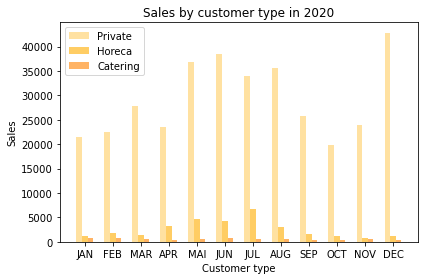

In [39]:
#sales by customer in 2020
sales_by_customer_type(2020)


## 3.5 How often did a customer purchase at the company at different days 

In [42]:
def get_frequency(cust_id ):
    
    transactions = hvc_visitresult
    # get transactions made by customer
    transactions_cust = transactions[hvc_hvvisitresult["SO0_NRID"] == cust_id]

    # get transactions from succesfull visits
    transactions_cust = transactions_cust[transactions_cust["HVOUTCOME_NRID"] == 2]

    # get total number of unique days on which customer made a purchase
    frequency = len(transactions_cust)
    
    # return
    return(frequency)

In [43]:
# check
get_frequency(721110.0)

NameError: name 'hvc_visitresult' is not defined

## 3.6 Which customers left the company?

In [44]:
#Linear regression 

def get_regression_sales(customer_id, year_regression):
    
    #get the month of each transaction date and store it in new column
    hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

    #merge
    transactions = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")
    
    #get transactions from desired_year
    transactions = transactions[(transactions["DATEONLY"] >= pd.Timestamp(year=year_regression, day=1, month=1)) & (transactions["DATEONLY"] < pd.Timestamp(year=year_regression + 1, month=1, day=1))]

    #get transactions with succesfull outcome
    transactions = transactions[transactions["HVOUTCOME_NRID"] == 2]
    
    #get transactions from customer with specific id 
    transactions_unique_cust = transactions[transactions["SO0_NRID"] == customer_id ]
    
    # get the total sales for each month for 'private customers'
    sales_unique_cust = transactions_unique_cust.groupby("MONTH")["AMOUNT"].sum().reset_index() 

    
    sns.lmplot(x="MONTH", y="AMOUNT", data=sales_unique_cust, fit_reg=True)
    plt.xlabel("Months")
    plt.ylabel("Sales")
    plt.title('Sales by customer ' + str(customer_id) +  ' in ' + str( year_regression))
    plt.xticks(np.arange(12),('JAN', 'FEB', 'MAR', 'APR', 'MAI', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
    plt.show()


In [45]:
# Regression test
get_regression_sales(customer_id=721110.0, year_regression=2019)

NameError: name 'sns' is not defined

In [46]:
# Now lets take a look at the aggregated sales of the different segments 

def get_sales_segement(segment, year_regression):
    
    
    #get the month of each transaction date and store it in new column
    hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

    #merge
    transactions = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")
    
    #get transactions from desired_year
    transactions = transactions[(transactions["DATEONLY"] >= pd.Timestamp(year=year_regression, day=1, month=1)) & (transactions["DATEONLY"] < pd.Timestamp(year=year_regression + 1, month=1, day=1))]

    #get transactions with succesfull outcome
    transactions = transactions[transactions["HVOUTCOME_NRID"] == 2]
    
    #get transactions from customer with specific id 
    transactions_segment = transactions[transactions["CUST_TYPE"] == segment ]
    
    # get the total sales for each month for 'private customers'
    sales_segment = transactions_segment.groupby("MONTH")["AMOUNT"].sum().reset_index() 

    
    sns.lmplot(x="MONTH", y="AMOUNT", data=sales_segment, fit_reg=True)
    plt.xlabel("Months")
    plt.ylabel("Sales")
    plt.title('Sales by customer segment in ' + str( year_regression))
    plt.xticks(np.arange(12),('JAN', 'FEB', 'MAR', 'APR', 'MAI', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
    plt.show()


In [47]:
# test  sales by segment
get_sales_segement(Catering,2020)


NameError: name 'Catering' is not defined

In [50]:
#check if the customers that left in 2020 gave a bad review in 2019

def get_regression_sales_info(customer_id):
    
    info_reg_no_sales = [1.0, 0.0,-1.0]
    
    try:
        #get the month of each transaction date and store it in new column
        hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

        #merge
        transactions = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")
    
        #get transactions from desired_year
        transactions = transactions[(transactions["DATEONLY"] >= pd.Timestamp(year=2020, day=1, month=1)) & (transactions["DATEONLY"] < pd.Timestamp(year=2021, month=1, day=1))]

        #get transactions with succesfull outcome
        transactions = transactions[transactions["HVOUTCOME_NRID"] == 2]
    
        #get transactions from customer with specific id 
        transactions_unique_cust = transactions[transactions["SO0_NRID"] == customer_id ]
    
        # get the total sales for each month for customers
        sales_unique_cust = transactions_unique_cust.groupby("MONTH")["AMOUNT"].sum().reset_index() 
        #print(sales_unique_cust)
        sales_unique_cust_fixed = sales_unique_cust
        sales_unique_cust_fixed["MONTH"] = sales_unique_cust["MONTH"]-1
    
        #regression model
        x = np.array(sales_unique_cust_fixed["MONTH"]).reshape((-1,1))
        y = np.array(sales_unique_cust_fixed["AMOUNT"])
        model = LinearRegression()
        model.fit(x,y)
    
        #coefficient of determination
        r_sq = model.score(x,y)
    
        #intercept and slope
        intercept = model.intercept_
        slope = model.coef_
    
        info_reg = [r_sq, intercept,slope[0]]
    
        return info_reg
    
    except ValueError as v:
        return info_reg_no_sales

In [52]:
#setting thresholds for leaving customers
threshold_r_sq = 0.500000000
threshold_slope = 0.000

In [53]:
#getting a list of leaving customers
leaving_customers = []

for i in range(len(hvc_so0)):
    #getting the neccesary information 
    info_regression = get_regression_sales_info(customer_id=hvc_so0.iloc[i,0])
    try:
        #checking with thresholds
        if ((info_regression[0] > threshold_r_sq) and (info_regression[2] < threshold_slope)):
            leaving_customers.append(hvc_so0.iloc[i,0])    
        #if no sales records in 2020
        elif (info_regression == [1.0, 0.0,-1.0]):
            leaving_customers.append(hcv_so0.iloc[i,0])
        
    except TypeError:
        print("TypeError")

NameError: name 'LinearRegression' is not defined

In [54]:
len(leaving_customers)

0

In [55]:
leaving_customers = np.array(leaving_customers)

In [56]:
# save numpy array as npy fil
# save to npy file
np.save('./data/leaving_customers.npy', leaving_customers)

In [57]:
# load numpy array from npy file
# load array
# leaving_customers = np.load('./data/leaving_customers.npy')))


In [58]:
#customers with bad reviews
hvc_all_bad_reviews = hvc_customer_reviews[(hvc_customer_reviews["REVIEW"] == "Not completely satisfied") | (hvc_customer_reviews["REVIEW"] == "Very bad service, very unsatisfied")]
customers_all_bad_reviews = hvc_all_bad_reviews["SO0_NRID"].to_numpy()

In [59]:
hvc_terrible_reviews = hvc_customer_reviews[(hvc_customer_reviews["REVIEW"] == "Very bad service, very unsatisfied")]
customers_terrible_reviews = hvc_terrible_reviews["SO0_NRID"].to_numpy()

In [60]:
#check the intersection of bad customers with the leaving customers
bad_review_leaving = np.intersect1d(leaving_customers,customers_all_bad_reviews)

#check the intersection of terrible customers with the leaving customers
terrible_review_leaving = np.intersect1d(leaving_customers,customers_terrible_reviews)

In [61]:
#calculating the proportion of all bad reviews that are leaving customers out of the total customers with all bad reviews
proportion_bad = int((100*len(bad_review_leaving))/len(customers_all_bad_reviews))
proportion_bad

#half of the customers that gave a bad review in 2019 are leaving customers in 2020 according to our regression 

0

In [62]:
#calculating the proportion of terrible reviews that are leaving customers out of the total customers with terrible reviews
proportion_terrible = int((100*len(terrible_review_leaving))/len(customers_terrible_reviews))
proportion_terrible

0

## 3.7 Clusters of customers 


Clustering Multi Vairiable Data  

In [ ]:
#Linear regression

## 3.8 Do customers have different buying patterns during the weekend?

In [63]:
# join transactions with customers
cust_transactions = pd.merge(hvc_hvvisitresult, hvc_so0, on="SO0_NRID", how="inner")

# get transactions with succesfull outcome
cust_transactions = cust_transactions[cust_transactions["HVOUTCOME_NRID"] == 2 and cust_transactions[""]]

# create boxplot for transaction amounts for weekend
sns.boxplot(x=cust_transactions["AMOUNT"], y=cust_transactions[""] == )
plt.show()


SyntaxError: invalid syntax (<ipython-input-63-b49b86f00e6c>, line 8)

## 3.9 Do customer sales differ across different cities? Is there a relationship between customer


In [64]:
# import customer locations
pos_df = pd.read_csv("./data/HVC_HVPOSITION_CORRECT.csv", sep=";")

# join
cust_pos_df = pd.merge(left=hvc_so0, right=pos_df, on="SO0_NRID", how="inner")

In [65]:
# import city data from belgium, which was downloaded from the internet
postcodes_df = pd.read_csv("./data/zipcode-belgium.csv", header=None)
postcodes_df.columns = ["POSTCODE", "LOCATION", "LAT", "LONG"]

In [66]:
cust_pos_df

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE,LAT,LONG
0,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946
1,721110,219020601,Private,3930,nl-BE,All time,3.591994,50.956946
2,721121,219020601,Private,3930,nl-BE,All time,3.604466,50.958559
3,721126,219020601,Private,3930,nl-BE,All time,3.603056,50.958251
4,721131,219020601,Private,3930,nl-BE,All time,3.603824,50.958419
...,...,...,...,...,...,...,...,...
4068,56130125,289657598,Private,3500,nl-BE,All time,4.784574,50.850181
4069,56132008,219023167,Private,3930,nl-BE,All time,3.607610,51.080591
4070,56138665,289762482,Private,3680,nl-BE,All time,4.570060,51.212260
4071,56142048,289760478,Private,3650,nl-BE,All time,4.644759,51.217775


In [67]:
pos_df

,SO0_NRID,LAT,LONG
0,724196,3.576301,51.053585
1,724219,3.572461,51.047222
2,724231,3.571065,51.044908
3,724236,3.568838,51.041573
4,724241,3.567592,51.040040
...,...,...,...
5692,25332076406640,4.573422,51.154883
5693,25335568268048,3.844218,51.119432
5694,25343276433048,3.867731,51.061335
5695,25345568238048,3.802616,51.038216


In [68]:
# join with customer data
cust_pos_postcodes_df = pd.merge(left=cust_pos_df, right=postcodes_df, on="POSTCODE", how="inner")
cust_pos_postcodes_df

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE,LAT_x,LONG_x,LOCATION,LAT_y,LONG_y
0,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Achel,5.479290,51.268431
1,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Hamont,5.531287,51.254585
2,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Hamont-Achel,5.512870,51.254764
3,721110,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Achel,5.479290,51.268431
4,721110,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Hamont,5.531287,51.254585
...,...,...,...,...,...,...,...,...,...,...,...
11123,1398075,289659602,Private,3600,nl-BE,All time,4.621416,50.994857,Genk,5.500146,50.965486
11124,1398086,289659602,Private,3600,nl-BE,All time,4.620606,50.996574,Genk,5.500146,50.965486
11125,1398096,289659602,Private,3600,nl-BE,All time,4.619796,50.998291,Genk,5.500146,50.965486
11126,1398101,289659602,Private,3600,nl-BE,All time,4.619796,50.998291,Genk,5.500146,50.965486


In [69]:
def change_postcode_customer(cust_id):
    # get index of customer
    index = cust_pos_postcodes_df[cust_pos_postcodes_df['SO0_NRID']==cust_id].index.values.astype(int)[0]
    index_so0 = hvc_so0[hvc_so0['SO0_NRID']==cust_id].index.values.astype(int)[0]
    # get long and lat from customer
    cust_long = float(cust_pos_postcodes_df["LONG_x"].iloc[index])
    cust_lat = float(cust_pos_postcodes_df["LAT_x"].iloc[index])
    
    closest_city = None
    closest_dist = 10000000
    
    for i in range(len(postcodes_df)):
        city_name = postcodes_df["LOCATION"].iloc[i]
        city_long = float(postcodes_df["LONG"].iloc[i])
        city_lat = float(postcodes_df["LAT"].iloc[i])
        
        city=(city_lat, city_long)
        cust=(cust_lat, cust_long)
        
        dist = hs.haversine(city,cust)
        if dist < closest_dist:
            closest_city = city_name
            closest_dist = dist
    
    city_postcode = postcodes_df[postcodes_df["LOCATION"] == closest_city]["POSTCODE"]
    #hvc_so0.set(index_so0, 'POSTCODE', city_postcode)
    hvc_so0.at[index_so0, 'POSTCODE'] = city_postcode
    #hvc_so0[index_so0]["POSTCODE"] = city_postcode
    #hvc_so0.loc[index_so0, 4] = city_postcode


In [70]:
#change postcode for all customers
for index, row in hvc_so0.iterrows():
    if(cust_id in cust_pos_df):
        cust_id = hvc_so0["SO0_NRID"].get(index)
        change_postcode_customer(cust_id)

NameError: name 'cust_id' is not defined

In [71]:
hvc_so0

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE
0,721104,219020601,Private,3930,nl-BE,All time
1,721110,219020601,Private,3930,nl-BE,All time
2,721121,219020601,Private,3930,nl-BE,All time
3,721126,219020601,Private,3930,nl-BE,All time
4,721131,219020601,Private,3930,nl-BE,All time
...,...,...,...,...,...,...
5704,-2147483648,219020601,Horeca,3930,nl-BE,All time
5705,-2147483648,289760478,Horeca,3650,nl-BE,All time
5706,-2147483648,289760478,Private,3680,nl-BE,All time
5707,-2147483648,289418953,Private,3550,nl-BE,All time
